# SimCLR Contrastive Training for Human Activity Recognition Tutorial

In [1]:
# Author: C. I. Tang
# Based on work of Tang et al.: https://arxiv.org/abs/2011.11542
# Contact: cit27@cl.cam.ac.uk
# License: GNU General Public License v3.0

%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

2023-06-15 20:41:58.621978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold

sns.set_context('poster')

In [4]:
# Library scripts
import raw_data_processing
import data_pre_processing   
import simclr_models
import simclr_utitlities
import transformations

In [8]:
working_directory = 'test_run/'
print(working_directory)

test_run/


In [9]:
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.mkdir(working_directory)


## MotionSense Dataset

In this section, the MotionSense dataset will be downloaded and parsed. The results will then be saved in a python pickle file.
(Note: This section only needs to be run once)

Citation:
```
@inproceedings{Malekzadeh:2019:MSD:3302505.3310068,
author = {Malekzadeh, Mohammad and Clegg, Richard G. and Cavallaro, Andrea and Haddadi, Hamed},
title = {Mobile Sensor Data Anonymization},
booktitle = {Proceedings of the International Conference on Internet of Things Design and Implementation},
series = {IoTDI '19},
year = {2019},
isbn = {978-1-4503-6283-2},
location = {Montreal, Quebec, Canada},
pages = {49--58},
numpages = {10},
url = {http://doi.acm.org/10.1145/3302505.3310068},
doi = {10.1145/3302505.3310068},
acmid = {3310068},
publisher = {ACM},
address = {New York, NY, USA},
keywords = {adversarial training, deep learning, edge computing, sensor data privacy, time series analysis},
}
```

### Downloading & Unzipping

In [6]:
import requests
import zipfile

In [9]:
#dataset_url = 'https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip?raw=true'

#r = requests.get(dataset_url, allow_redirects=True)
#with open(working_directory + 'B_Accelerometer_data.zip', 'wb') as f:
#    f.write(r.content)

In [10]:
#with zipfile.ZipFile(working_directory + 'B_Accelerometer_data.zip', 'r') as zip_ref:
#    zip_ref.extractall(working_directory)

### Data Processing

In [10]:
accelerometer_data_folder_path = working_directory + 'B_Accelerometer_data/'
user_datasets = raw_data_processing.process_motion_sense_accelerometer_files(accelerometer_data_folder_path)

test_run/B_Accelerometer_data/dws_1
test_run/C_Gyroscope_data/dws_1
test_run/B_Accelerometer_data/dws_11
test_run/C_Gyroscope_data/dws_11
test_run/B_Accelerometer_data/dws_2
test_run/C_Gyroscope_data/dws_2
test_run/B_Accelerometer_data/jog_16
test_run/C_Gyroscope_data/jog_16
test_run/B_Accelerometer_data/jog_9
test_run/C_Gyroscope_data/jog_9
test_run/B_Accelerometer_data/sit_13
test_run/C_Gyroscope_data/sit_13
test_run/B_Accelerometer_data/sit_5
test_run/C_Gyroscope_data/sit_5
test_run/B_Accelerometer_data/std_14
test_run/C_Gyroscope_data/std_14
test_run/B_Accelerometer_data/std_6
test_run/C_Gyroscope_data/std_6
test_run/B_Accelerometer_data/ups_12
test_run/C_Gyroscope_data/ups_12
test_run/B_Accelerometer_data/ups_3
test_run/C_Gyroscope_data/ups_3
test_run/B_Accelerometer_data/ups_4
test_run/C_Gyroscope_data/ups_4
test_run/B_Accelerometer_data/wlk_15
test_run/C_Gyroscope_data/wlk_15
test_run/B_Accelerometer_data/wlk_7
test_run/C_Gyroscope_data/wlk_7
test_run/B_Accelerometer_data/wlk_8


In [12]:
with open(working_directory + 'motion_sense_user_split.pkl', 'wb') as f:
    pickle.dump({
        'user_split': user_datasets,
    }, f)

## Pre-processing

In [13]:
# Parameters
window_size = 100
input_shape = (window_size, 6)

# Dataset Metadata
transformation_multiple = 1
dataset_name = 'motion_sense.pkl'
dataset_name_user_split = 'motion_sense_user_split.pkl'

label_list = ['null', 'sit', 'std', 'wlk', 'ups', 'dws', 'jog']
label_list_full_name = ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
has_null_class = True

label_map = dict([(l, i) for i, l in enumerate(label_list)])

output_shape = len(label_list)

model_save_name = f"motionsense_acc"

sampling_rate = 50.0
unit_conversion = scipy.constants.g

# a fixed user-split
test_users_fixed = [1, 14, 19, 23, 6]
def get_fixed_split_users(har_users):
    # test_users = har_users[0::5]
    test_users = test_users_fixed
    train_users = [u for u in har_users if u not in test_users]
    return (train_users, test_users)

In [14]:
with open(dataset_save_path + dataset_name_user_split, 'rb') as f:
    dataset_dict = pickle.load(f)
    user_datasets = dataset_dict['user_split']

In [15]:
har_users = list(user_datasets.keys())
train_users, test_users = get_fixed_split_users(har_users)
print(f'Testing: {test_users}, Training: {train_users}')

Testing: [1, 14, 19, 23, 6], Training: [10, 11, 12, 13, 15, 16, 17, 18, 2, 20, 21, 22, 24, 3, 4, 5, 7, 8, 9]


In [16]:
string = "'test_run/B_Accelerometer_data/wlk_8'"

# replace all instances of 'r' (old) with 'e' (new)
new_string = string.replace("B_Accelerometer_data", "C_Gyroscope_data" )

print(string)
print(new_string)


'test_run/B_Accelerometer_data/wlk_8'
'test_run/C_Gyroscope_data/wlk_8'


Here we convert the original dataset into a windowed one, and split it into training, validation and testing sets.

In [17]:
np_train, np_val, np_test = data_pre_processing.pre_process_dataset_composite(
    user_datasets=user_datasets,
    label_map=label_map,
    output_shape=output_shape,
    train_users=train_users,
    test_users=test_users,
    window_size=window_size,
    shift=window_size//2,
    normalise_dataset=True,
    verbose=1
)

/home/elian.riveros/dl-13-elian/notebooks/workspaces/lstm-har/TFC-pretraining-1/code/baselines/SimCLR/data_pre_processing.py:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return scipy.stats.mode(np_array)[0]


Test
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([ 512,  569, 1463, 1371,  648, 1376]))
(array([1, 2, 3, 4, 5, 6]), array([1463, 1371, 1376,  648,  512,  569]))
-----------------
Train
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([2018, 2045, 5242, 4689, 2393, 5403]))
(array([1, 2, 3, 4, 5, 6]), array([5242, 4689, 5403, 2393, 2018, 2045]))
-----------------
Training data shape: (17432, 100, 6)
Validation data shape: (4358, 100, 6)
Testing data shape: (5939, 100, 6)


An alternative processing pipeline can be used to retain the user id as a feature and/or a label in the output dataset.

Note: This is not used in the study, and thus is commented in this notebook.

In [ ]:
# user_datasets_processed = data_pre_processing.pre_process_dataset_composite_in_user_format(
#     user_datasets=user_datasets,
#     label_map=label_map,
#     output_shape=output_shape,
#     train_users=train_users,
#     window_size=window_size,
#     shift=window_size//2,
#     normalise_dataset=True,
#     verbose=1
# )

# user_datasets_with_user_ids, user_id_mapping = data_pre_processing.add_user_id_to_windowed_dataset(
#     user_datasets_processed,
#     encode_user_id=True,
#     as_feature=True,
#     as_label=False,
#     verbose=1
# )

# train_x, train_y, test_x, test_y = data_pre_processing.combine_windowed_dataset(user_datasets_with_user_ids, train_users)
# train_x_split, val_x_split, train_y_split, val_y_split = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# np_train = (train_x_split, train_y_split)
# np_val = (val_x_split, val_y_split)
# np_test = (test_x, test_y)

# print("Training data shape:", train_x_split.shape)
# print("Validation data shape:", val_x_split.shape)
# print("Testing data shape:", test_x.shape)

## My dataset

## SimCLR Training

In [18]:
batch_size = 512
decay_steps = 1000
epochs = 200
temperature = 0.1
transform_funcs = [
    # transformations.scaling_transform_vectorized, # Use Scaling trasnformation
    transformations.rotation_transform_vectorized # Use rotation trasnformation
]
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

# trasnformation_indices = [2] # Use rotation trasnformation only
# trasnformation_indices = [1, 2] # Use Scaling and rotation trasnformation

# trasnform_funcs_vectorized = [
#     transformations.noise_transform_vectorized,
#     transformations.scaling_transform_vectorized,
#     transformations.rotation_transform_vectorized,
#     transformations.negate_transform_vectorized,
#     transformations.time_flip_transform_vectorized,
#     transformations.time_segment_permutation_transform_improved,
#     transformations.time_warp_transform_low_cost,
#     transformations.channel_shuffle_transform_vectorized
# ]
# transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']



0 <function rotation_transform_vectorized at 0x7fd3e14371f0>


In [20]:
np_train[0].shape

(17432, 100, 6)

In [26]:
input_shape

(100, 6)

In [24]:
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
tf.keras.backend.set_floatx('float32')

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)
# transformation_function = simclr_utitlities.generate_combined_transform_function(trasnform_funcs_vectorized, indices=trasnformation_indices)

base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)

In [25]:
simclr_model.summary()

Model: "base_model_simclr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 6)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 77, 32)            4640      
                                                                 
 dropout_9 (Dropout)         (None, 77, 32)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 62, 64)            32832     
                                                                 
 dropout_10 (Dropout)        (None, 62, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 55, 96)            49248     
                                                                 
 dropout_11 (Dropout)        (None, 55, 96)      

In [22]:
with tf.device('/gpu:0'):
    trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(simclr_model, np_train[0], optimizer, batch_size, transformation_function, temperature=temperature, epochs=epochs, is_trasnform_function_vectorized=True, verbose=1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 6)

In [ ]:

    simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
    trained_simclr_model.save(simclr_model_save_path)

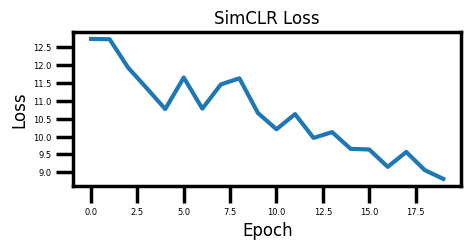

In [16]:
plt.figure(figsize=(5,2))
plt.plot(epoch_losses)
plt.ylabel("Loss", fontsize = 12)
# change font size of axis labels
plt.tick_params(axis='both', which='major', labelsize=6)
# change size of labels
plt.title("SimCLR Loss", fontsize = 12)

plt.xlabel("Epoch", fontsize = 12)
plt.show()

## Fine-tuning and Evaluation

### Linear Model

In [26]:
simclr_model_save_path

'test_run/20230614-214834_simclr.hdf5'

In [31]:
linear_evaluation_model.summary()

Model: "base_model_simclrlinear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 377, 32)           2336      
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 355, 96)           49248     
                                                                 
 dropout_2 (Dropout)         (None, 355, 96

In [97]:
np_test[1][0] = [1., 0., 0., 0., 0., 0., 0.]

In [32]:
total_epochs = 10
batch_size = 200
tag = "linear_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(linear_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = linear_evaluation_model.fit(
    x = np_train[0],
    y = np_train[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val
)

linear_eval_best_model = tf.keras.models.load_model(linear_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(linear_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Epoch 1/10
21/21 [==============================] - 1s 25ms/step - loss: 1.3595 - categorical_accuracy: 0.4741 - auc: 0.8474 - precision: 0.8628 - recall: 0.2505 - val_loss: 1.2265 - val_categorical_accuracy: 0.5935 - val_auc: 0.9026 - val_precision: 0.9320 - val_recall: 0.2761
Epoch 2/10
21/21 [==============================] - 0s 16ms/step - loss: 1.1399 - categorical_accuracy: 0.6284 - auc: 0.9113 - precision: 0.8925 - recall: 0.3664 - val_loss: 1.1155 - val_categorical_accuracy: 0.7440 - val_auc: 0.9295 - val_precision: 0.9284 - val_recall: 0.3480
Epoch 3/10
21/21 [==============================] - 0s 20ms/step - loss: 1.0453 - categorical_accuracy: 0.7507 - auc: 0.9338 - precision: 0.8874 - recall: 0.4083 - val_loss: 1.0461 - val_categorical_accuracy: 0.7584 - val_auc: 0.9420 - val_precision: 0.9182 - val_recall: 0.3873
Epoch 4/10
21/21 [==============================] - 0s 19ms/step - loss: 0.9764 - categorical_accuracy: 0.7702 - auc: 0.9449 - precision: 0.8867 - recall: 0.4206 -

### Full HAR Model

In [142]:
!pwd

/home/elian.riveros/dl-13-elian/notebooks/workspaces/lstm-har/TFC-pretraining-1/code/baselines/SimCLR


In [143]:
print(np_train[0].shape)
print(np_train[1].shape)
print(np_val[0].shape)
print(np_val[1].shape)
print(np_test[0].shape)
print(np_test[1].shape)

(4168, 400, 3)
(4168, 7)
(1043, 400, 3)
(1043, 7)
(1419, 400, 3)
(1419, 7)


In [140]:
root = "/home/elian.riveros/dl-13-elian/notebooks/workspaces"
file_name = "lstm-har/gatednet_ax2Sns/dataset/UEA_archive/BasicMotions"
dataset = 'cola'
train_X_path = root + '/' + file_name + '/' + 'X_train_'+dataset+'_3ch.npy'
train_Y_path = root + '/' + file_name + '/' + 'y_train_'+dataset+'.npy'
val_X_path = root + '/' + file_name + '/' + 'X_val_'+dataset+'_3ch.npy'
val_Y_path = root + '/' + file_name + '/' + 'y_val_'+dataset+'.npy'        
test_X_path = root + '/' + file_name + '/' + 'X_test_'+dataset+'_3ch.npy'
test_Y_path = root + '/' + file_name + '/' + 'y_test_'+dataset+'.npy'

train_X = np.load(train_X_path)
train_Y = np.load(train_Y_path)
val_X = np.load(val_X_path)
val_Y = np.load(val_Y_path)
test_X = np.load(test_X_path)
test_Y = np.load(test_Y_path)

In [144]:
print("Shapes:")
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

Shapes:
(8075, 100, 6) (8075,)
(8855, 100, 6) (8855,)
(3015, 100, 6) (3015,)


In [159]:
train_Y_onehot= tf.one_hot(train_Y, 7)
val_Y_onehot= tf.one_hot(val_Y, 7)
test_Y_onehot= tf.one_hot(test_Y, 7)

In [158]:
type(np_train)

tuple

In [171]:
np_train2 = (train_X, train_Y_onehot)
np_val2 = (val_X, val_Y_onehot)

In [27]:
simclr_model_save_path = "test_run/20230614-021725_simclr.hdf5"

In [155]:
simclr_model_save_path

'test_run/20230614-214834_simclr.hdf5'

In [180]:
total_epochs = 50
batch_size = 200
tag = "full_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
full_evaluation_model = simclr_models.create_full_classification_model_from_base_model(simclr_model, output_shape, model_name="TPN", intermediate_layer=7, last_freeze_layer=4)

inputs: KerasTensor(type_spec=TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 400, 3), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'") at layer "conv1d". The following previous layers were accessed without issue: []

In [174]:
full_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
full_eval_best_model_file_name

'test_run/20230614-214834_simclr_full_eval.hdf5'

In [177]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint(full_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = full_evaluation_model.fit(
    x = np_train2[0],
    y = np_train2[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val2
)

full_eval_best_model = tf.keras.models.load_model(full_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(full_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(full_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Epoch 1/50


ValueError: in user code:

    File "/home/elian.riveros/miniconda3/envs/tensor/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/elian.riveros/miniconda3/envs/tensor/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/elian.riveros/miniconda3/envs/tensor/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/elian.riveros/miniconda3/envs/tensor/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/elian.riveros/miniconda3/envs/tensor/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/elian.riveros/miniconda3/envs/tensor/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "TPN" is incompatible with the layer: expected shape=(None, 400, 3), found shape=(None, 100, 6)


In [120]:
full_evaluation_model.summary()

Model: "TPN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 377, 32)           2336      
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 355, 96)           49248     
                                                                 
 dropout_2 (Dropout)         (None, 355, 96)           0       

## Extra: t-SNE Plots

### Parameters

In [121]:
# Select a model from which the intermediate representations are extracted
target_model = simclr_model
perplexity = 30.0


In [118]:
simclr_model.summary()

Model: "base_model_simclr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 377, 32)           2336      
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 355, 96)           49248     
                                                                 
 dropout_2 (Dropout)         (None, 355, 96)     

### t-SNE Representations

In [44]:
intermediate_model = simclr_models.extract_intermediate_model_from_base_model(target_model, intermediate_layer=7)
intermediate_model.summary()

embeddings = intermediate_model.predict(np_test[0], batch_size=600)
tsne_model = sklearn.manifold.TSNE(perplexity=perplexity, verbose=1, random_state=42)
tsne_projections = tsne_model.fit_transform(embeddings)



Model: "base_model_simclr_layer_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 377, 32)           2336      
                                                                 
 dropout (Dropout)           (None, 377, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 362, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 362, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 355, 96)           49248     
                                                                 
 dropout_2 (Dropout)         (None, 355, 

### Plotting

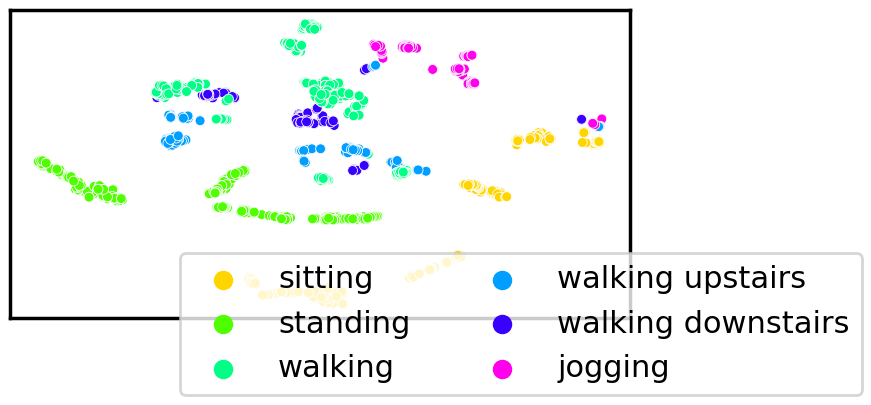

In [46]:
labels_argmax = np.argmax(np_test[1], axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(8,4))
graph = sns.scatterplot(
    x=tsne_projections[:,0], y=tsne_projections[:,1],
    hue=labels_argmax,
    palette=sns.color_palette("hsv", len(unique_labels)),
    s=50,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label])

### Custom Color maps (Optional)

This section can be run to produce plots where semantically similar classes share similar colors. This requires the definition of a custom mapping of classes to colors.

In [ ]:
# This is used to select colors for labels which are close to each other
# Each pair corresponds to one label class
# i.e. ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
# The first number determines the color map, and the second determines its value along the color map
# So 'sitting', 'standing' will share similar colors, and 'walking', 'walking upstairs', 'walking downstairs' will share another set of similar colors
label_color_spectrum = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0)]

# This step generates a list of colors for different categories of activities
# Here we assume 5 categories, and 5 different intesities within each category
major_colors = ['cool', 'Blues', 'Greens', 'Oranges', 'Purples']
color_map_base = dict (
    [((i, j), color) for i, major_color in enumerate(major_colors) for j, color in enumerate(reversed(sns.color_palette(major_color, 5))) ]
)
color_palette = np.array([color_map_base[color_index] for color_index in label_color_spectrum])

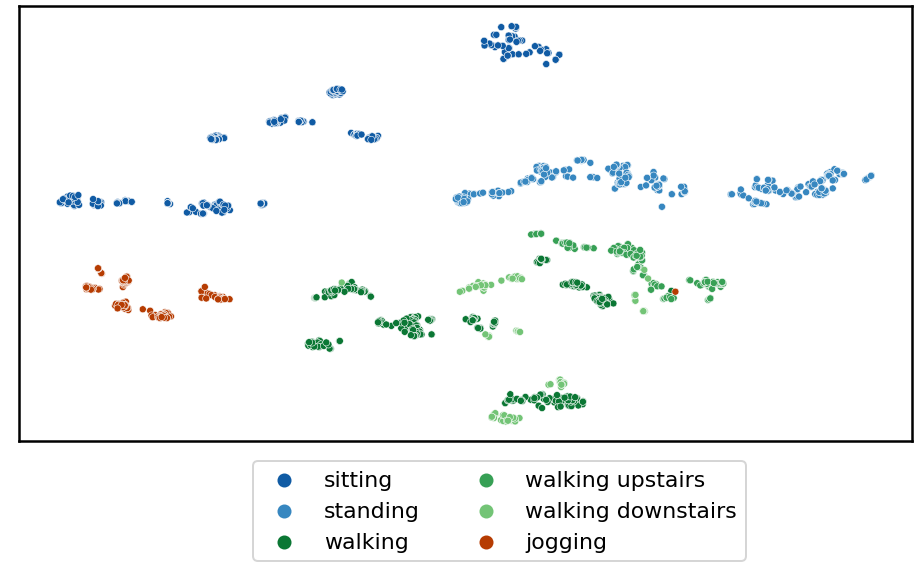

In [ ]:
# This selects the appropriate number of colors to be used in the plot
labels_argmax = np.argmax(np_test[1], axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(16,8))
graph = sns.scatterplot(
    x=tsne_projections[:,0], y=tsne_projections[:,1],
    hue=labels_argmax,
    palette=list(color_palette[unique_labels]),
    s=50,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label])
